# 训练

In [1]:
# ./scripts/mmdet_train.sh retinanet

In [1]:
gpu_id = 0

# 变量定义

In [2]:
import glob
import os

# 参数
model_name = 'retinanet'
model_stru = ''
model_cfg = ''
img_size = 1333
exp_name = f'{model_name}{model_stru}{model_cfg}_{img_size}'

# 路径
cfg_path = f'cfg/mmdet/{model_name}_{img_size}.py'
best_model_path = f'runs/mmdetection/{exp_name}/train/'
exp_id = max([f for f in os.listdir(best_model_path) if os.path.isdir(os.path.join(best_model_path, f))])  # 最新实验
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmdetection/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='retinanet_1333'
best_model_path='runs/mmdetection/retinanet_1333/train/best_coco_bbox_mAP_epoch_214.pth'
train_log_path='runs/mmdetection/retinanet_1333/train/20231213_150310/vis_data/scalars.json'


# 日志分析

['lr', 'data_time', 'loss', 'loss_cls', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (214)0.922


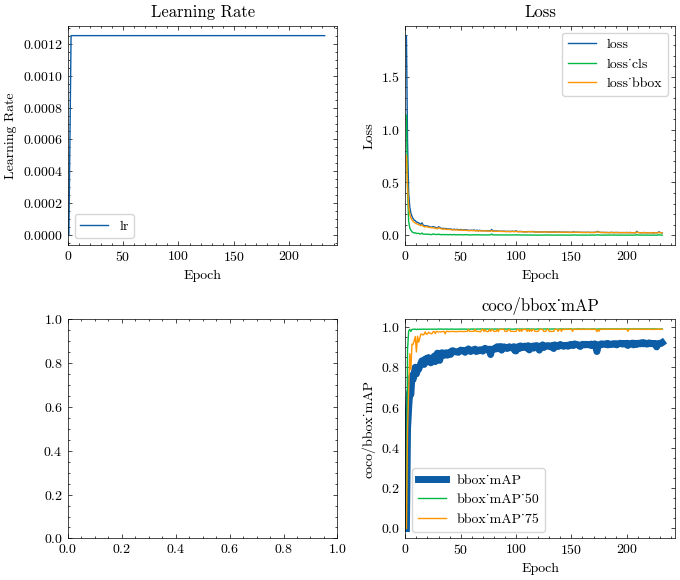

In [3]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmdet_retinanet_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmdet_retinanet_train_log(df_train, df_val, exp_name=exp_name)

# 测试

In [4]:
! scripts/mmdet_test.sh {cfg_path} {best_model_path} {exp_name} {gpu_id}

06/02 23:02:14 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: None
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;

# 评估

In [5]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmdetection/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.27s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.659,0.593,0.331,0.549,0.607
"AP (IoU=0.50, area=all, maxDets=100)",0.968,0.854,0.601,0.812,0.897
"AP (IoU=0.75, area=all, maxDets=100)",0.767,0.678,0.319,0.618,0.698
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.194,0.111,0.180,0.180
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.556,0.496,0.228,0.456,0.502
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.714,0.789,0.435,0.720,0.714
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.738,0.649,0.377,0.602,0.677
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.739,0.652,0.381,0.605,0.679
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.739,0.652,0.381,0.605,0.679
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.233,0.137,0.218,0.218


In [7]:
# from src.utils.plot import plot_pr_curve

# plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 参数量

In [6]:
# ! scripts/mmdet_flops.sh {cfg_path}

import argparse
import importlib
import pandas as pd
from mmengine.logging import MMLogger
module = importlib.import_module("3rdparty.mmdetection.tools.analysis_tools.get_flops")
inference = module.inference

args = argparse.Namespace(
    config=cfg_path,
    num_images=1,
    cfg_options=dict()
)
logger = MMLogger.get_instance(name='MMLogger')
result = inference(args, logger)
split_line = '=' * 30
ori_shape = result['ori_shape']
pad_shape = result['pad_shape']
flops = result['flops']
params = result['params']
compute_type = result['compute_type']

if pad_shape != ori_shape:
    print(f'{split_line}\nUse size divisor set input shape '
            f'from {ori_shape} to {pad_shape}')
print(f'{split_line}\nCompute type: {compute_type}\n'
        f'Input shape: {pad_shape}\nFlops: {flops}\n'
        f'Params: {params}\n{split_line}')

# 数据重构
all_complex = {}
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:
    all_complex[data_type] = [params, flops]  # 仅为便于数据拼接
all_complex = pd.DataFrame(
    data=all_complex,
    index=['Param', 'FLOPs']
)

# 合并复杂度指标
all_metrics = pd.concat([all_metrics, all_complex], axis=0)
all_metrics

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
06/02 23:14:15 - mmengine - WARNING - Unsupported operator aten::max_pool2d encountered 1 time(s)
06/02 23:14:15 - mmengine - WARNING - Unsupported operator aten::add_ encountered 16 time(s)
06/02 23:14:15 - mmengine - WARNING - Unsupported operator aten::add encountered 2 time(s)
06/02 23:14:15 - mmengine - WARNING - The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
bbox_head.loss_bbox, bbox_head.loss_cls, bbox_head.relu, data_preprocessor
06/02 23:14:15 - mmengine - WARNING - Unsupported operator aten::batch_norm encountered 53 time(s)
06/02 23:14:15 - mmengine - WARNING - Unsupported operator aten::upsample_nearest2d encountered 2 tim

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.658579,0.592903,0.330716,0.549406,0.606962
"AP (IoU=0.50, area=all, maxDets=100)",0.967793,0.854186,0.600502,0.812049,0.896770
"AP (IoU=0.75, area=all, maxDets=100)",0.766675,0.677610,0.318790,0.618034,0.697639
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.193640,0.111038,0.179752,0.179726
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.555812,0.495559,0.227819,0.456039,0.501644
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.713521,0.788587,0.435110,0.720493,0.713975
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.738427,0.648600,0.377170,0.601988,0.677231
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.739195,0.651533,0.381350,0.605135,0.679070
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.739195,0.651533,0.381350,0.605135,0.679070
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.232738,0.136667,0.218182,0.218182


# 测速

In [7]:
! scripts/mmdet_speed.sh {cfg_path} {best_model_path} {gpu_id}

06/02 23:14:42 - mmengine - INFO - before build: 
06/02 23:14:42 - mmengine - INFO - (GB) mem_used: 5.31 | uss: 0.29 | pss: 0.40 | total_proc: 1
Loads checkpoint by local backend from path: runs/mmdetection/retinanet_1333/train/best_coco_bbox_mAP_epoch_214.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
06/02 23:14:43 - mmengine - INFO - after build: 
06/02 23:14:43 - mmengine - INFO - (GB) mem_used: 5.63 | uss: 0.62 | pss: 0.74 | total_proc: 1
06/02 23:15:20 - mmengine - INFO - ==================================
06/02 23:15:20 - mmengine - INFO - Done image [500/2000], fps: 38.2 img/s, times per image: 26.2 ms/img, cuda memory: 373 MB
06/02 23:15:20 - mmengine - INFO - (GB) mem_used: 5.81 | uss: 0.83 | pss: 0.99 | total_proc: 1
06/02 23:15:56 - mmengine - INFO - ==================================
06/02 23:15:56 - mmengine - INFO - Done image [1000/2000], fps: 38.2 img/s, times per image: 26.2 ms/img, cuda memory: 373 MB
06/02 23:15:56 - mmengine 

In [14]:
# 06/02 23:17:08 - mmengine - INFO - ============== Done ==================
# 06/02 23:17:08 - mmengine - INFO - Overall fps: 38.2 img/s, times per image: 26.2 ms/img

# 06/02 23:19:55 - mmengine - INFO - ============== Done ==================
# 06/02 23:19:55 - mmengine - INFO - Overall fps: 32.5 img/s, times per image: 30.8 ms/img

# 06/02 23:20:34 - mmengine - INFO - ============== Done ==================
# 06/02 23:20:34 - mmengine - INFO - Overall fps: 32.5 img/s, times per image: 30.8 ms/img

# 06/02 23:23:54 - mmengine - INFO - ============== Done ==================
# 06/02 23:23:54 - mmengine - INFO - Overall fps: 32.4 img/s, times per image: 30.9 ms/img

# 06/02 23:26:22 - mmengine - INFO - ============== Done ==================
# 06/02 23:26:22 - mmengine - INFO - Overall fps: 38.4 img/s, times per image: 26.0 ms/img

In [8]:
# 保存结果
all_speed = {
    'test_synth': [26.2, 38.2],  # [average_time, fps]
    'test_real_nominal': [30.8, 32.5],
    'test_real_edge': [30.8, 32.5],
    'test_real': [30.9, 32.4],
    'test': [26.0, 38.4]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Time', 'FPS']
)

# 合并测试指标
all_metrics = pd.concat([all_metrics, all_speed], axis=0)
all_metrics

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.658579,0.592903,0.330716,0.549406,0.606962
"AP (IoU=0.50, area=all, maxDets=100)",0.967793,0.854186,0.600502,0.812049,0.896770
"AP (IoU=0.75, area=all, maxDets=100)",0.766675,0.677610,0.318790,0.618034,0.697639
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.193640,0.111038,0.179752,0.179726
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.555812,0.495559,0.227819,0.456039,0.501644
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.713521,0.788587,0.435110,0.720493,0.713975
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.738427,0.648600,0.377170,0.601988,0.677231
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.739195,0.651533,0.381350,0.605135,0.679070
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.739195,0.651533,0.381350,0.605135,0.679070
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.232738,0.136667,0.218182,0.218182


In [9]:
all_metrics.index.name = 'metrics'
all_metrics.to_csv(
    f'results/tables/metrics/baseline/metrics_baseline_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [10]:
# from src.utils.database import write_detections_2_database
# write_detections_2_database(lib_type='mmdetection', exp_name=exp_name)


In [9]:
# from src.utils.database import delete_detections_from_database
# delete_detections_from_database(exp_name=exp_name)
